# Netflix Stock Price Evaluation (LSTM model)

On this project, we are going to create a LSTM (Long short-term memory) model to predict the Netflix stock price using the historical data.

In [1]:
# Load the required libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the data 
dat = pd.read_csv('NFLX.csv')

In [3]:
# Explore the data 
dat.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000
1,2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800
2,2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400
3,2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800
4,2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200


In [4]:
# Drop missing values, if any
df = dat.dropna()

In [5]:
# Get the trading days 
df.shape

(4797, 7)

There are 4797 trading days.

## Time series plot of the Netflix Stock Price (Close Price)

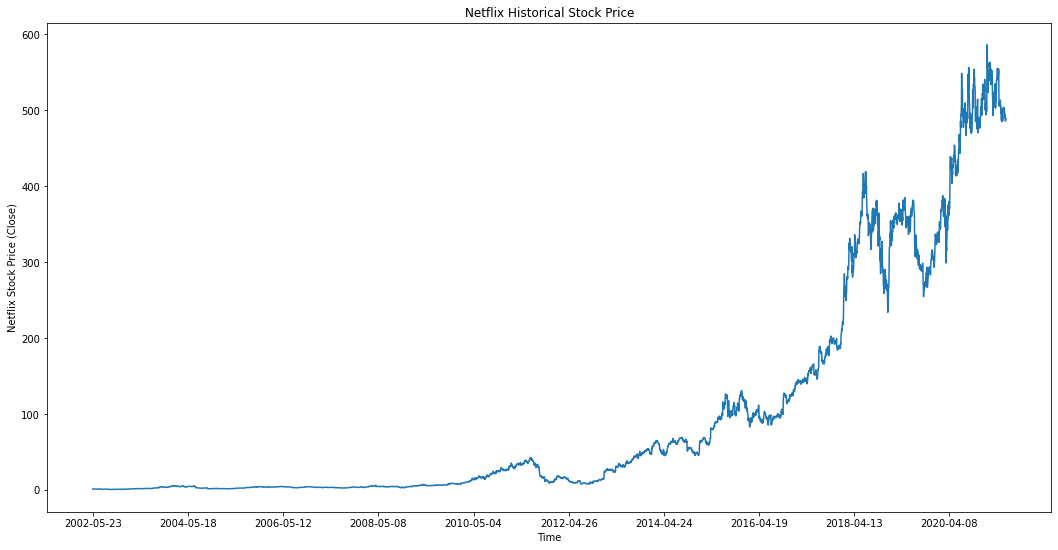

In [6]:
# Visualize the historical data
plt.figure(figsize = (18,9))
plt.plot(df.loc[:, 'Date'],dat.iloc[:, 4:5].values)
plt.xticks(np.arange(0,4797,500))
plt.xlabel('Time')
plt.ylabel('Netflix Stock Price (Close)')
plt.title('Netflix Historical Stock Price')
plt.show()

# Building LSTM Model for Prediction

In [7]:
# Install nsepy library 
!pip install -U -q tensorflow
!pip install -U -q nsepy
!pip install -U -q keras

In [8]:
# Import the libraries
from nsepy import get_history as gh
import datetime as dt
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler

In [11]:
# Split the train data and test data
training_set = df.iloc[:4675, 4:5].values
test_set = df.iloc[4675:, 4:5].values

# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

X_train = []
y_train = []

# Reshape X_train because LSTMs expect the data to be in a specific format, usually a 3D array.
# Choose 60 because we want to use the past 60 days' stock prices to predict the next day's stock price.
for i in range(60, 4675):
    X_train.append(training_set_scaled[i-60:i])
    y_train.append(training_set_scaled[i])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

We will build the LSTM with 50 neurons and 4 hidden layers. We add the LSTM layer and later add a few Dropout layers to prevent overfitting. We add the LSTM layer with the following arguments:

50 units which is the dimensionality of the output space
return_sequences=True which determines whether to return the last output in the output sequence, or the full sequence
input_shape as the shape of our training set.
When defining the Dropout layers, we specify 0.2, meaning that 20% of the layers will be dropped. Thereafter, we add the Dense layer that specifies the output of 1 unit. After this, we compile our model using the popular adam optimizer and set the loss as the mean_squarred_error. This will compute the mean of the squared errors. Next, we fit the model to run on 100 epochs with a batch size of 25. 

In [12]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (len(X_train), 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Generally batch size of 32 or 25 is good, with epochs = 100 unless you have large dataset.
# For large dataset, a batch size of 10, and epochs between 50 and 100 are recommended.
# Fitting the RNN to the Training set.
# A recurrent neural network (RNN) is a class of artificial neural networks 
# where connections between nodes form a directed graph along a temporal sequence.
model.fit(X_train, y_train, epochs = 100, batch_size = 25)

Epoch 1/100
185/185 [==============================] - 28s 53ms/step - loss: 0.0054
Epoch 2/100
185/185 [==============================] - 10s 54ms/step - loss: 0.0017
Epoch 3/100
185/185 [==============================] - 10s 55ms/step - loss: 0.0011
Epoch 4/100
185/185 [==============================] - 11s 58ms/step - loss: 0.0015
Epoch 5/100
185/185 [==============================] - 10s 54ms/step - loss: 0.0012
Epoch 6/100
185/185 [==============================] - 11s 57ms/step - loss: 9.8888e-04
Epoch 7/100
185/185 [==============================] - 11s 58ms/step - loss: 0.0011
Epoch 8/100
185/185 [==============================] - 13s 72ms/step - loss: 0.0010
Epoch 9/100
185/185 [==============================] - 11s 57ms/step - loss: 0.0011
Epoch 10/100
185/185 [==============================] - 10s 54ms/step - loss: 8.0416e-04
Epoch 11/100
185/185 [==============================] - 10s 53ms/step - loss: 8.0479e-04
Epoch 12/100
185/185 [==============================] - 9s 50m

In [13]:
# Test Data (reshape them to a 3D array)
dataset_train = df.iloc[:4675, 4:5]
dataset_test = df.iloc[4675:, 4:5]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)

inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = sc.transform(inputs)
inputs = inputs.reshape(-1,1)
X_test = []
for i in range(60, 182):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(X_test.shape)

(122, 60, 1)


In [14]:
# Making prediction using the test set data
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

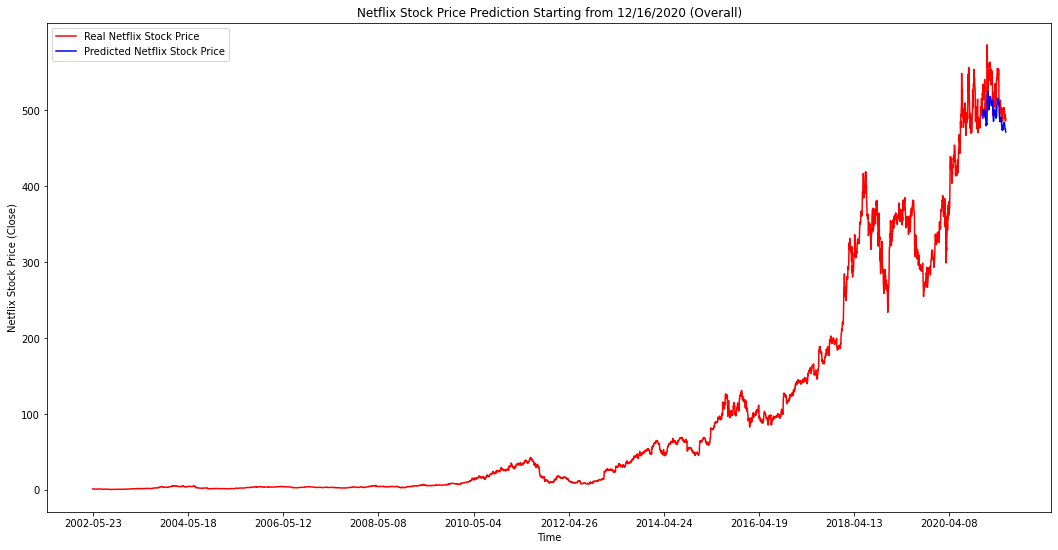

In [15]:
# Visualize the results(Real vs. Predicted)
# Real Netfilx stock price in red, and predicted stock price in blue

plt.figure(figsize = (18,9))
plt.plot(df.loc[:, 'Date'],dat.iloc[:, 4:5].values, color = 'red', label = 'Real Netflix Stock Price')
plt.plot(df.loc[4675:, 'Date'],predicted_stock_price, color = 'blue', label = 'Predicted Netflix Stock Price')
plt.yticks(np.arange(0,600,100))
plt.xticks(np.arange(0,4797,500))
plt.title('Netflix Stock Price Prediction Starting from 12/16/2020 (Overall)')
plt.xlabel('Time')
plt.ylabel('Netflix Stock Price (Close)')
plt.legend()
plt.show()

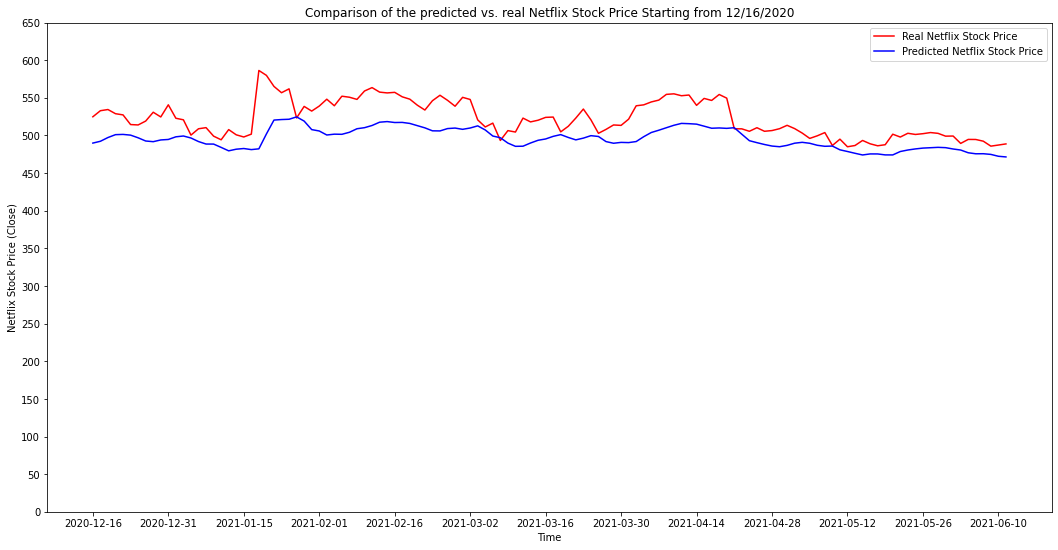

In [16]:
# Comparison of the predicted vs. real Netflix Stock Price
plt.figure(figsize = (18,9))
plt.plot(df.loc[4675:, 'Date'],dat.iloc[4675:, 4:5].values, color = 'red', label = 'Real Netflix Stock Price')
plt.plot(df.loc[4675:, 'Date'],predicted_stock_price, color = 'blue', label = 'Predicted Netflix Stock Price')
plt.xticks(np.arange(0,122,10))
plt.yticks(np.arange(0,700,50))
plt.title('Comparison of the predicted vs. real Netflix Stock Price Starting from 12/16/2020')
plt.xlabel('Time')
plt.ylabel('Netflix Stock Price (Close)')
plt.legend()
plt.show()

In [17]:
# RMSE for LSTM Model for 122 test data points
rmse_lstm = (np.mean((dataset_test - predicted_stock_price) ** 2)) ** 0.5
print('RMSE for LSTM model:')
rmse_lstm

RMSE for LSTM model:


Close    30.468999
dtype: float64

In this plot, we can see the predicted values are pretty close to the real values. The RMSE is also pretty small, which is 26.12.

## Predictions for the next 10 trading days


In [18]:
# Scale the entire dataset
sc = MinMaxScaler(feature_range = (0, 1))
dat_scaled = sc.fit_transform(df.iloc[:, 4:5].values)

dat_scaled

array([[0.00140549],
       [0.00142865],
       [0.00133845],
       ...,
       [0.82843744],
       [0.83092903],
       [0.8334889 ]])

In [19]:
# Reshape the dataset

X = []
y = []

# Reshape X because LSTMs expect the data to be in a specific format, usually a 3D array.
# Choose 60 because we want to use the past 60 days' stock prices to predict the next day's stock price.
for i in range(60, 4797):
    X.append(dat_scaled[i-60:i])
    y.append(dat_scaled[i])
X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [21]:
# Fit the model using the entire dataset

model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (len(X), 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Generally batch size of 32 or 25 is good, with epochs = 100 unless you have large dataset.
# In case of large dataset you can go with batch size of 10 with epochs b/w 50 to 100.
# Fitting the RNN to the Training set
model.fit(X, y, epochs = 100, batch_size = 32)

Epoch 1/100
149/149 [==============================] - 14s 54ms/step - loss: 0.0097
Epoch 2/100
149/149 [==============================] - 8s 52ms/step - loss: 0.0016
Epoch 3/100
149/149 [==============================] - 8s 53ms/step - loss: 0.0018
Epoch 4/100
149/149 [==============================] - 8s 52ms/step - loss: 0.0017
Epoch 5/100
149/149 [==============================] - 8s 53ms/step - loss: 0.0016
Epoch 6/100
149/149 [==============================] - 8s 53ms/step - loss: 0.0013
Epoch 7/100
149/149 [==============================] - 8s 52ms/step - loss: 0.0011
Epoch 8/100
149/149 [==============================] - 8s 52ms/step - loss: 9.6827e-04
Epoch 9/100
149/149 [==============================] - 8s 54ms/step - loss: 0.0011
Epoch 10/100
149/149 [==============================] - 8s 56ms/step - loss: 0.0013
Epoch 11/100
149/149 [==============================] - 8s 53ms/step - loss: 0.0011
Epoch 12/100
149/149 [==============================] - 8s 52ms/step - loss: 9.8

In [22]:
# Create an array to store the predicted close stock prices
predictions = []
predictions_scaled = []

# Prediction for the first day
inputs2 = dat_scaled[4737:]
inputs2 = inputs2.reshape(-1,1)

mat = []
for i in range(60, 61):
    mat.append(inputs2[i-60:i, 0])
mat = np.array(mat)
mat = np.reshape(mat, (1, 60, 1))
predicted_stock_price_scaled = model.predict(mat)
predicted_stock_price = sc.inverse_transform(predicted_stock_price_scaled)
predictions = np.append(predictions, predicted_stock_price)
predictions_scaled = np.append(predictions_scaled, predicted_stock_price_scaled)

In [23]:
# Prediction for the second day
inputs2 = np.append(dat_scaled[4738:], predictions_scaled)
inputs2 = inputs2.reshape(-1,1)

mat = []
for i in range(60, 61):
    mat.append(inputs2[i-60:i, 0])
mat = np.array(mat)
mat = np.reshape(mat, (1, 60, 1))

predicted_stock_price_scaled = model.predict(mat)
predicted_stock_price = sc.inverse_transform(predicted_stock_price_scaled)
predictions = np.append(predictions, predicted_stock_price)
predictions_scaled = np.append(predictions_scaled, predicted_stock_price_scaled)

In [24]:
# Prediction for the third day
inputs2 = np.append(dat_scaled[4739:], predictions_scaled)
inputs2 = inputs2.reshape(-1,1)

mat = []
for i in range(60, 61):
    mat.append(inputs2[i-60:i, 0])
mat = np.array(mat)
mat = np.reshape(mat, (1, 60, 1))

predicted_stock_price_scaled = model.predict(mat)
predicted_stock_price = sc.inverse_transform(predicted_stock_price_scaled)
predictions = np.append(predictions, predicted_stock_price)
predictions_scaled = np.append(predictions_scaled, predicted_stock_price_scaled)

In [25]:
# Prediction for the 4th day
inputs2 = np.append(dat_scaled[4740:], predictions_scaled)
inputs2 = inputs2.reshape(-1,1)

mat = []
for i in range(60, 61):
    mat.append(inputs2[i-60:i, 0])
mat = np.array(mat)
mat = np.reshape(mat, (1, 60, 1))

predicted_stock_price_scaled = model.predict(mat)
predicted_stock_price = sc.inverse_transform(predicted_stock_price_scaled)
predictions = np.append(predictions, predicted_stock_price)
predictions_scaled = np.append(predictions_scaled, predicted_stock_price_scaled)

In [26]:
# Prediction for the 5th day
inputs2 = np.append(dat_scaled[4741:], predictions_scaled)
inputs2 = inputs2.reshape(-1,1)

mat = []
for i in range(60, 61):
    mat.append(inputs2[i-60:i, 0])
mat = np.array(mat)
mat = np.reshape(mat, (1, 60, 1))

predicted_stock_price_scaled = model.predict(mat)
predicted_stock_price = sc.inverse_transform(predicted_stock_price_scaled)
predictions = np.append(predictions, predicted_stock_price)
predictions_scaled = np.append(predictions_scaled, predicted_stock_price_scaled)

In [27]:
# Prediction for the 6th day
inputs2 = np.append(dat_scaled[4742:], predictions_scaled)
inputs2 = inputs2.reshape(-1,1)

mat = []
for i in range(60, 61):
    mat.append(inputs2[i-60:i, 0])
mat = np.array(mat)
mat = np.reshape(mat, (1, 60, 1))

predicted_stock_price_scaled = model.predict(mat)
predicted_stock_price = sc.inverse_transform(predicted_stock_price_scaled)
predictions = np.append(predictions, predicted_stock_price)
predictions_scaled = np.append(predictions_scaled, predicted_stock_price_scaled)

In [28]:
# Prediction for the 7th day
inputs2 = np.append(dat_scaled[4743:], predictions_scaled)
inputs2 = inputs2.reshape(-1,1)

mat = []
for i in range(60, 61):
    mat.append(inputs2[i-60:i, 0])
mat = np.array(mat)
mat = np.reshape(mat, (1, 60, 1))

predicted_stock_price_scaled = model.predict(mat)
predicted_stock_price = sc.inverse_transform(predicted_stock_price_scaled)
predictions = np.append(predictions, predicted_stock_price)
predictions_scaled = np.append(predictions_scaled, predicted_stock_price_scaled)

In [29]:
# Prediction for the 8th day
inputs2 = np.append(dat_scaled[4744:], predictions_scaled)
inputs2 = inputs2.reshape(-1,1)

mat = []
for i in range(60, 61):
    mat.append(inputs2[i-60:i, 0])
mat = np.array(mat)
mat = np.reshape(mat, (1, 60, 1))

predicted_stock_price_scaled = model.predict(mat)
predicted_stock_price = sc.inverse_transform(predicted_stock_price_scaled)
predictions = np.append(predictions, predicted_stock_price)
predictions_scaled = np.append(predictions_scaled, predicted_stock_price_scaled)

In [30]:
# Prediction for the 9th day
inputs2 = np.append(dat_scaled[4745:], predictions_scaled)
inputs2 = inputs2.reshape(-1,1)

mat = []
for i in range(60, 61):
    mat.append(inputs2[i-60:i, 0])
mat = np.array(mat)
mat = np.reshape(mat, (1, 60, 1))

predicted_stock_price_scaled = model.predict(mat)
predicted_stock_price = sc.inverse_transform(predicted_stock_price_scaled)
predictions = np.append(predictions, predicted_stock_price)
predictions_scaled = np.append(predictions_scaled, predicted_stock_price_scaled)

In [31]:
# Prediction for the 10th day
inputs2 = np.append(dat_scaled[4746:], predictions_scaled)
inputs2 = inputs2.reshape(-1,1)

mat = []
for i in range(60, 61):
    mat.append(inputs2[i-60:i, 0])
mat = np.array(mat)
mat = np.reshape(mat, (1, 60, 1))

predicted_stock_price_scaled = model.predict(mat)
predicted_stock_price = sc.inverse_transform(predicted_stock_price_scaled)
predictions = np.append(predictions, predicted_stock_price)
predictions_scaled = np.append(predictions_scaled, predicted_stock_price_scaled)

In [32]:
# Predictions for the next 10 trading days
predictions

array([501.04330444, 505.30288696, 509.18252563, 511.91790771,
       513.87591553, 515.53369141, 517.11328125, 518.60614014,
       519.96905518, 521.1975708 ])

In [33]:
# Calculate confidence intervals

import scipy.stats as st

ci = st.t.interval(alpha=0.95, df=len(predictions)-1, loc=predictions, scale=st.sem(predictions)) 

In [34]:
# Predictions and CIs
pred_lstm = pd.DataFrame()
pred_lstm['Date'] = ['2021-06-14', '2021-06-15', '2021-06-16', '2021-06-17', '2021-06-18', '2021-06-21', '2021-06-22', '2021-06-23', '2021-06-24', '2021-06-25']
pred_lstm['Close'] = predictions
pred_lstm['Lower Interval'] = ci[0]
pred_lstm['Upper Interval'] = ci[1]
print("Next 10 Days' Netflix Stock Prediction")
pred_lstm = pred_lstm.set_index([np.arange(0,10), np.arange(4797, 4807)])
pred_lstm.reset_index(level=0, drop=True, inplace=True)
pred_lstm

Next 10 Days' Netflix Stock Prediction


,Date,Close,Lower Interval,Upper Interval
4797,2021-06-14,501.043304,496.347221,505.739388
4798,2021-06-15,505.302887,500.606803,509.998971
4799,2021-06-16,509.182526,504.486442,513.878609
4800,2021-06-17,511.917908,507.221824,516.613991
4801,2021-06-18,513.875916,509.179832,518.571999
4802,2021-06-21,515.533691,510.837608,520.229775
4803,2021-06-22,517.113281,512.417198,521.809365
4804,2021-06-23,518.606140,513.910057,523.302224
4805,2021-06-24,519.969055,515.272972,524.665139
4806,2021-06-25,521.197571,516.501487,525.893654


In [35]:
# Combine the entire data set with the prediction

result = pd.concat([dat, pred_lstm], axis=0, join="inner")

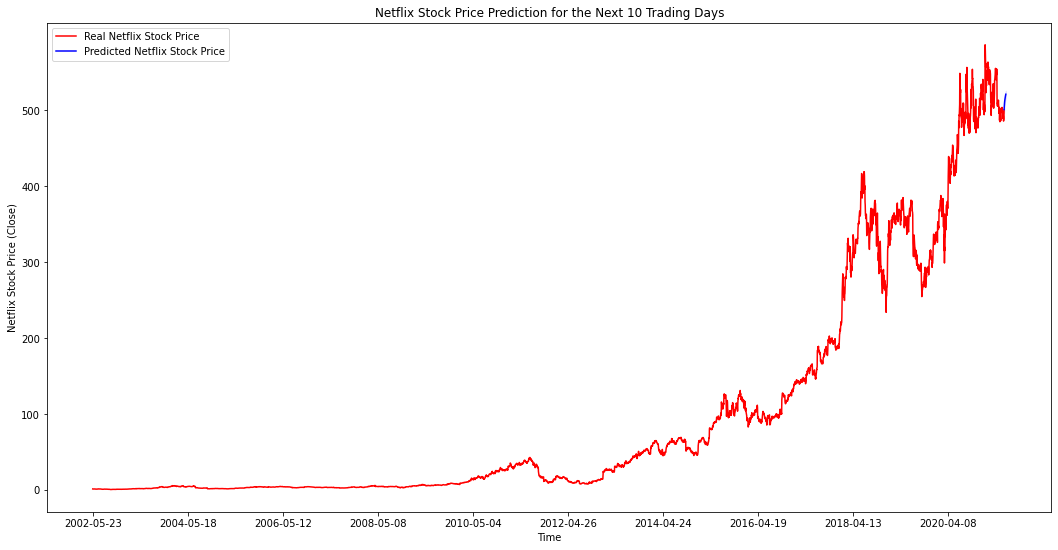

In [36]:
# Visualize the prediction results with 95% confidence interval

plt.figure(figsize = (18,9))
plt.plot(result.loc[:4797, 'Date'],result.loc[:4797, 'Close'].values, color = 'red', label = 'Real Netflix Stock Price')
plt.plot(result.loc[4797:, 'Date'],result.loc[4797:, 'Close'].values, color = 'blue', label = 'Predicted Netflix Stock Price')
plt.fill_between(result.loc[4797:, 'Date'], pred_lstm.loc[4797:, 'Lower Interval'].values, pred_lstm.loc[4797:, 'Upper Interval'].values, color='blue', alpha=0.1)
plt.yticks(np.arange(0,600,100))
plt.xticks(np.arange(0,4807,500))
plt.title('Netflix Stock Price Prediction for the Next 10 Trading Days')
plt.xlabel('Time')
plt.ylabel('Netflix Stock Price (Close)')
plt.legend()
plt.show()

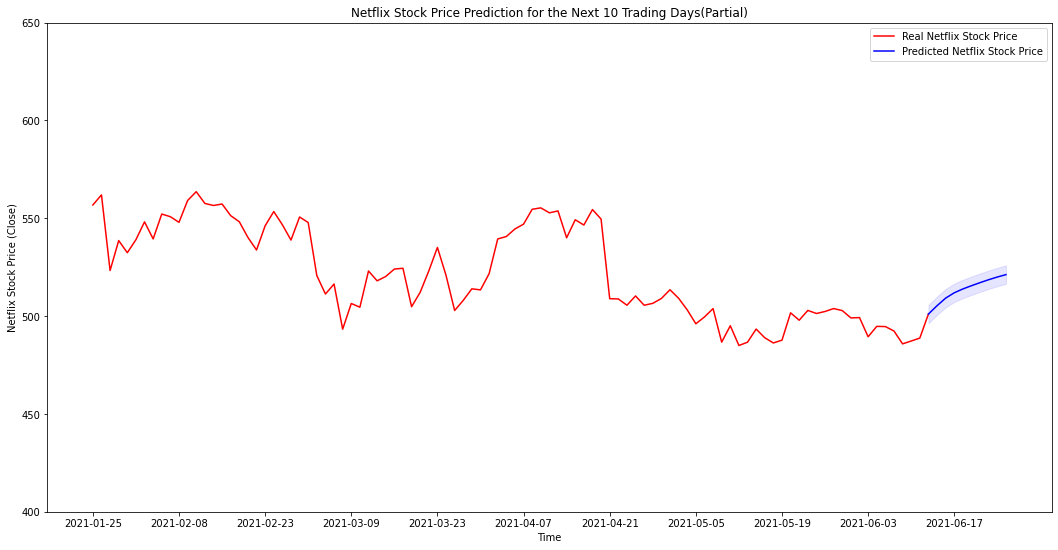

In [37]:
# Visualize the prediction results

plt.figure(figsize = (18,9))
plt.plot(result.loc[4700:4797, 'Date'],result.loc[4700:4797, 'Close'].values, color = 'red', label = 'Real Netflix Stock Price')
plt.plot(result.loc[4797:, 'Date'],result.loc[4797:, 'Close'].values, color = 'blue', label = 'Predicted Netflix Stock Price')
plt.fill_between(result.loc[4797:, 'Date'], pred_lstm.loc[4797:, 'Lower Interval'].values, pred_lstm.loc[4797:, 'Upper Interval'].values, color='blue', alpha=0.1)
plt.yticks(np.arange(400,700,50))
plt.xticks(np.arange(0,107,10))
plt.title('Netflix Stock Price Prediction for the Next 10 Trading Days(Partial)')
plt.xlabel('Time')
plt.ylabel('Netflix Stock Price (Close)')
plt.legend()
plt.show()